In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load datasets
# File 1: mountains.csv
mountains_url = 'https://drive.google.com/uc?id=10KW8aIbG2yZi1Xw545usPdrsprNZsdf4'
mountains_output = 'mountains.csv'
gdown.download(mountains_url, mountains_output, quiet=False)
mountains = pd.read_csv(mountains_output)

# File 2: weather.csv
weather_url = 'https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk'
weather_output = 'weather.csv'
gdown.download(weather_url, weather_output, quiet=False)
weather = pd.read_csv(weather_output)

Downloading...
From: https://drive.google.com/uc?id=10KW8aIbG2yZi1Xw545usPdrsprNZsdf4
To: /content/mountains.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 27.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk
From (redirected): https://drive.google.com/uc?id=1kzzLkqeBPVxUr-9Ec0GPsPR7UqtRdeMk&confirm=t&uuid=248715a0-0aed-4022-b9aa-4e5bd43c7dcd
To: /content/weather.csv
100%|██████████| 132M/132M [00:01<00:00, 90.8MB/s]


In [3]:
mountains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nama            207 non-null    object 
 1   provinsi        207 non-null    object 
 2   kabupaten       207 non-null    object 
 3   kecamatan       207 non-null    object 
 4   ketinggian      207 non-null    int64  
 5   jenis gunung    207 non-null    object 
 6   status          207 non-null    object 
 7   akses           207 non-null    object 
 8   jarak           207 non-null    int64  
 9   elevation gain  207 non-null    int64  
 10  latitude        207 non-null    float64
 11  longitude       207 non-null    float64
dtypes: float64(2), int64(3), object(7)
memory usage: 19.5+ KB


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408416 entries, 0 to 408415
Data columns (total 40 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   datetime        408416 non-null  object 
 1   datetimeepoch   408416 non-null  int64  
 2   tempmax         408416 non-null  float64
 3   tempmin         408416 non-null  float64
 4   temp            408416 non-null  float64
 5   feelslikemax    408416 non-null  float64
 6   feelslikemin    408416 non-null  float64
 7   feelslike       408416 non-null  float64
 8   dew             408416 non-null  float64
 9   humidity        408416 non-null  float64
 10  precip          408416 non-null  float64
 11  precipprob      408416 non-null  float64
 12  precipcover     408416 non-null  float64
 13  snow            408416 non-null  float64
 14  snowdepth       408416 non-null  float64
 15  windgust        408416 non-null  float64
 16  windspeed       408416 non-null  float64
 17  winddir   

In [5]:
# Merge on kecamatan
combined_df = pd.merge(weather, mountains, on='kecamatan', how='inner')

In [6]:
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])

# Sort by datetime
combined_df = combined_df.sort_values(by='datetime').reset_index(drop=True)

In [7]:
combined_df

,datetime,datetimeepoch,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,provinsi,kabupaten,ketinggian,jenis gunung,status,akses,jarak,elevation gain,latitude,longitude
0,2020-01-01,1577811600,31.1,20.6,24.8,36.9,20.6,26.0,22.0,85.6,...,sumatera utara,tapanuli selatan,1900,stratovolcano,tidak aktif,buka,11000,1000,1.478815,99.208871
1,2020-01-01,1577808000,30.1,24.7,27.4,37.4,24.7,30.9,24.9,86.3,...,bali,tabanan,2087,stratovolcano,tidak aktif,buka,10100,790,8.307259,115.101937
2,2020-01-01,1577811600,31.3,20.4,25.6,37.8,20.4,27.3,22.6,84.8,...,jawa tengah,kendal,2590,non volcanic,tidak aktif,buka,9000,600,7.033638,109.954152
3,2020-01-01,1577811600,31.3,20.4,25.6,37.8,20.4,27.3,22.6,84.8,...,jawa tengah,wonosobo,2365,maar volcano,tidak aktif,buka,3500,350,7.238485,109.888846
4,2020-01-01,1577808000,30.1,21.9,27.1,37.4,21.9,30.5,24.7,86.9,...,bali,badung,2096,caldera,tidak aktif,buka,14600,1462,8.247104,115.187623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440435,2025-05-20,1747674000,33.0,25.0,28.9,39.7,25.0,32.8,24.3,77.5,...,jawa barat,purwakarta,2050,stratovolcano,tidak aktif,buka,11000,1100,6.773272,107.555684
440436,2025-05-20,1747670400,28.7,26.7,27.7,31.6,26.7,30.0,22.0,71.2,...,nusa tenggara timur,sikka,875,stratovolcano,aktif,tutup,13200,735,8.328063,121.713110
440437,2025-05-20,1747674000,29.4,22.2,24.9,32.8,22.2,25.8,22.4,86.6,...,jawa tengah,boyolali,2897,stratovolcano,aktif,tutup,8900,1300,7.539951,110.447011
440438,2025-05-20,1747670400,28.8,24.3,26.7,32.8,24.3,28.2,23.1,81.1,...,gorontalo,pahuwato,1539,extinct volcano,tidak aktif,buka,15000,1100,0.647312,121.248049


In [8]:
# cek info
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440440 entries, 0 to 440439
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        440440 non-null  datetime64[ns]
 1   datetimeepoch   440440 non-null  int64         
 2   tempmax         440440 non-null  float64       
 3   tempmin         440440 non-null  float64       
 4   temp            440440 non-null  float64       
 5   feelslikemax    440440 non-null  float64       
 6   feelslikemin    440440 non-null  float64       
 7   feelslike       440440 non-null  float64       
 8   dew             440440 non-null  float64       
 9   humidity        440440 non-null  float64       
 10  precip          440440 non-null  float64       
 11  precipprob      440440 non-null  float64       
 12  precipcover     440440 non-null  float64       
 13  snow            440440 non-null  float64       
 14  snowdepth       440440 non-null  flo

In [9]:
features = ['ketinggian', 'jarak', 'elevation gain', 'temp', 'precip', 'windspeed']

In [13]:
difficulty_scaler = MinMaxScaler()
difficulty_scaled_values = difficulty_scaler.fit_transform(combined_df[features])
difficulty_scaled_df = pd.DataFrame(
    difficulty_scaled_values,
    columns=[f'{col}_scaled' for col in features]
)
combined_df = pd.concat([combined_df.reset_index(drop=True), difficulty_scaled_df], axis=1)

In [14]:
# weighted difficulty score
def compute_difficulty_score_scaled(row):
    score = (
        0.25 * row['elevation gain_scaled'] +
        0.20 * row['jarak_scaled'] +
        0.25 * row['precip_scaled'] +
        0.15 * row['windspeed_scaled'] +
        0.10 * row['ketinggian_scaled'] +
        0.05 * row['temp_scaled']
    )
    return score * 10  # scale to 0–10

# Estimate time (Naismith rule)
def estimate_time(row):
    return (row['jarak'] / 5000) + (row['elevation gain'] / 600) + (row['difficulty_score'] / 10)

In [15]:
combined_df['difficulty_score'] = combined_df.apply(compute_difficulty_score_scaled, axis=1)
combined_df['estimated_time'] = combined_df.apply(estimate_time, axis=1)

In [ ]:
sns.histplot(combined_df['difficulty_score'], kde=True)
plt.title("Distribution of Difficulty Score")
plt.xlabel("Difficulty Score")
plt.ylabel("Frequency")
plt.show()

In [16]:
X = combined_df[features]
y = combined_df[['difficulty_score', 'estimated_time']]

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [11]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    diff = K.abs((y_true - y_pred) / y_true)
    return 100. * K.mean(diff)

In [12]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', mean_absolute_percentage_error]
)

In [13]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
11011/11011 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.7644 - mae: 0.1812 - mean_absolute_percentage_error: 4.8582 - val_loss: 9.4835e-05 - val_mae: 0.0080 - val_mean_absolute_percentage_error: 0.2097
Epoch 2/10
11011/11011 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 7.3270e-05 - mae: 0.0043 - mean_absolute_percentage_error: 0.1228 - val_loss: 7.5350e-07 - val_mae: 4.5650e-04 - val_mean_absolute_percentage_error: 0.0184
Epoch 3/10
11011/11011 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 7.6828e-05 - mae: 0.0028 - mean_absolute_percentage_error: 0.0844 - val_loss: 8.4074e-05 - val_mae: 0.0084 - val_mean_absolute_percentage_error: 0.2579
Epoch 4/10
11011/11011 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 6.1827e-05 - mae: 0.0036 - mean_absolute_percentage_error: 0.1050 - val_loss: 1.9047e-06 - val_mae: 9.0087e-04 - val_mean_absolute_percentage_error: 0.0210
Epoch 5/10
11011/11011 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 6.2876e-05 - mae: 0.0027 - mean_absolute_percentage_error: 0.07

In [15]:
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

In [16]:
y_pred = model.predict(X_val)
adj_r2 = adjusted_r2_score(y_val, y_pred, X_val.shape[1])
print(f"Adjusted R²: {adj_r2:.4f}")

2753/2753 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Adjusted R²: 1.0000


2753/2753 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


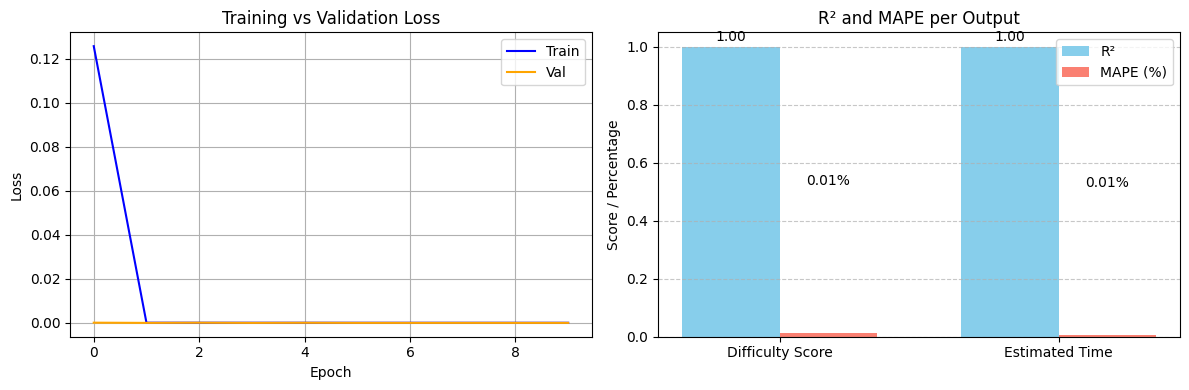

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Predict on Validation Set
y_pred = model.predict(X_val)
y_true = y_val.to_numpy()

titles = ['Difficulty Score', 'Estimated Time']
n_samples, n_features = y_true.shape

mape_list = []
r2_list = []

for i, name in enumerate(titles):
    true = y_true[:, i]
    pred = y_pred[:, i]

    # R²
    r2 = r2_score(true, pred)
    r2_list.append(r2)

    # MAPE
    true_safe = np.where(true == 0, np.finfo(float).eps, true)  # avoid division by zero
    mape = np.mean(np.abs((true - pred) / true_safe)) * 100
    mape_list.append(mape)

x = np.arange(len(titles))
width = 0.35

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Training vs Validation Loss
ax1.plot(history.history['loss'], label='Train', color='blue')
ax1.plot(history.history['val_loss'], label='Val', color='orange')
ax1.set_title("Training vs Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Plot 2: R² and MAPE
ax2.bar(x - width/2, r2_list, width, label='R²', color='skyblue')
ax2.bar(x + width/2, mape_list, width, label='MAPE (%)', color='salmon')

ax2.set_ylabel("Score / Percentage")
ax2.set_title("R² and MAPE per Output")
ax2.set_xticks(x)
ax2.set_xticklabels(titles)
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on bars
for i, v in enumerate(r2_list):
    ax2.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
for i, v in enumerate(mape_list):
    ax2.text(i + width/2, v + 0.5, f"{v:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [19]:
new_input = pd.DataFrame([{
    'ketinggian': 7156,
    'jarak': 20000,
    'elevation gain': 6500,
    'temp': 22.5,
    'precip': 4.5,
    'windspeed': 10
}])

new_scaled = score_scaler.transform(new_input[features])
pred_difficulty, pred_time = model.predict(new_scaled)[0]

print(f"Predicted Difficulty Score: {pred_difficulty:.2f} / 10")
print(f"Estimated Time: {pred_time:.2f} hours")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Predicted Difficulty Score: 7.09 / 10
Estimated Time: 15.75 hours
